In [112]:
# 用 PyTorch 进行 手写数字识别
import torch
from tqdm import tqdm
import numpy as np
from torch import nn
import torchvision
from torch.utils import data
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
mnist = datasets.MNIST(root = '~', train = True, download = True)

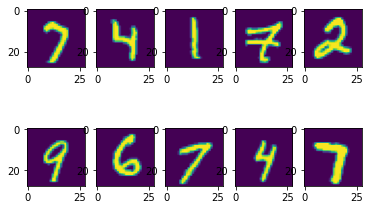

In [18]:
for i, j in enumerate(np.random.randint(0, len(mnist), (10,))):
    data, label = mnist[j]
    plt.subplot(2, 5, i + 1)
    plt.imshow(data)

In [16]:
np.random.randint(0, len(mnist), (10,))

array([55682, 29731, 49253, 14069, 42350,  8339, 28686, 35645, 58848,
       21584])

In [17]:
len(mnist)

60000

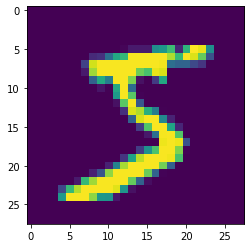

In [21]:
data1, label1 = mnist[0]
plt.imshow(data1)

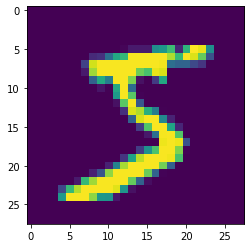

In [23]:
plt.imshow(mnist[0][0])

In [22]:
# 数字 5
label1

5

In [24]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081))])
normalized = trans(mnist[0][0])
mnist = datasets.MNIST(root = '~', train = True, download = True, transform = trans)

In [25]:
def imshow(img):
    img = img * 0.3081 + 0.1307
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [29]:
dataloader = data.DataLoader(mnist, batch_size = 4, shuffle = True, num_workers = 4)
images, labels = next(iter(dataloader))

In [32]:
images.size(), labels.size()

(torch.Size([4, 1, 28, 28]), torch.Size([4]))

In [38]:
torchvision.utils.make_grid(images).size()

torch.Size([3, 32, 122])

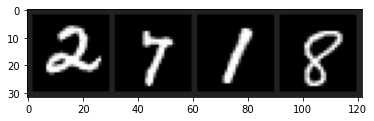

In [39]:
imshow(torchvision.utils.make_grid(images))

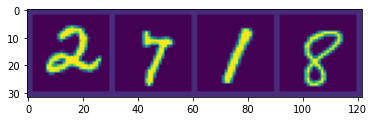

In [45]:
imshow(torchvision.utils.make_grid(images)[1:2])

In [53]:
(torchvision.utils.make_grid(images))[0:1].size(), (torchvision.utils.make_grid(images))[0].size()

(torch.Size([1, 32, 122]), torch.Size([32, 122]))

In [87]:
a = np.random.randint(0, 255, (28, 28))
a = torch.from_numpy(a)
a.size()

torch.Size([28, 28])

In [88]:
b = a.resize(1, 28, 28)
b.size()

torch.Size([1, 28, 28])

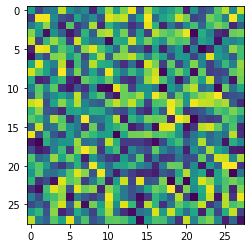

In [89]:
imshow(b)

In [90]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.inputlayer = nn.Sequential(nn.Linear(28 * 28, 256), nn.ReLU(), nn.Dropout(0.2))
        self.hiddenlayer = nn.Sequential(nn.Linear(256, 256), nn.ReLU(), nn.Dropout(0.2))
        self.outlayer = nn.Sequential(nn.Linear(256, 10))
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.inputlayer(x)
        x = self.hiddenlayer(x)
        x = self.outlayer(x)
        return x

In [91]:
print(MLP())

MLP(
  (inputlayer): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (hiddenlayer): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (outlayer): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [95]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST(root = '~', train = True, download = True, transform = trans)
mnist_val = datasets.MNIST(root = '~', train = False, download = True, transform = trans)
trainloader = data.DataLoader(mnist_train, batch_size = 16, shuffle = True, num_workers = 4)
valloader = data.DataLoader(mnist_val, batch_size = 16, shuffle = True, num_workers = 4)

In [102]:
for data1, target1 in valloader:
    print(data1.size(), target1.size())
    break

torch.Size([16, 1, 28, 28]) torch.Size([16])


In [103]:
model1 = MLP()
output1 = model1(data1)
output1.size()

torch.Size([16, 10])

In [104]:
data2 = data1.view(data1.size(0), -1)
data2.size()  # 把图片维度拉直，batchsize = 16

torch.Size([16, 784])

In [105]:
# 模型
model = MLP()
# 优化器
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
# 损失函数
celoss = nn.CrossEntropyLoss()
best_acc = 0

In [106]:
# 计算准确率
def accuracy(pred, target):
    pred_label = torch.argmax(pred, 1)
    correct = sum(pred_label == target).to(torch.float)
    # acc = correct / float(len(pred))
    return correct, len(pred)

In [107]:
acc = {'train': [], 'val': []}
loss_all = {'train': [], 'val': []}

In [113]:
for epoch1 in tqdm(range(10)):
    print(epoch1)

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2506.76it/s]

0
1
2
3
4
5
6
7
8
9


In [118]:
for epoch in tqdm(range(10)):
    # 设置为验证模式
    model.eval()
    numer_val, denumer_val, loss_tr = 0., 0., 0. 
    with torch.no_grad():
        for data, target in valloader:
            output = model(data)
            loss = celoss(output, target)
            loss_tr += loss.data
            num, denum = accuracy(output, target)
            numer_val += num
            denumer_val += denum
    # 设置为训练模式
    model.train()
    numer_tr, denumer_tr, loss_val = 0., 0., 0.
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = celoss(output, target)
        loss_val += loss.data
        loss.backward()
        optimizer.step()
        num, denum = accuracy(output, target)
        numer_tr += num
        denumer_tr += denum
    loss_all['train'].append(loss_tr / len(trainloader))
    loss_all['val'].append(loss_val / len(valloader))
    acc['train'].append(numer_tr / denumer_tr)
    acc['val'].append(numer_val / denumer_val)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:39<00:00, 27.91s/it]


In [110]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

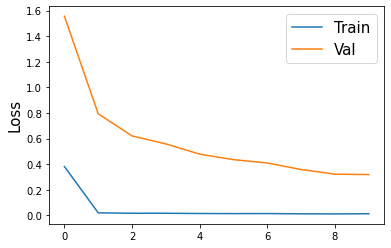

In [124]:
plt.plot(loss_all['train'], label = 'Train')
plt.plot(loss_all['val'], label = 'Val')
plt.ylabel('Loss', fontsize = 15)
plt.legend(fontsize = 15)

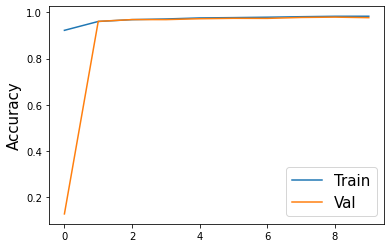

In [126]:
plt.plot(acc['train'], label = 'Train')
plt.plot(acc['val'], label = 'Val')
plt.ylabel('Accuracy', fontsize = 15)
plt.legend(fontsize = 15)